In [2]:
import pandas as pd
from NegativeClassOptimization import datasets
import seaborn as sns
import NegativeClassOptimization.config as config
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.stats import pearsonr

In [3]:
def add_median_labels(
    ax,
    fmt=".2f",
    fontsize=6,
    y_level=None,
    y_offset=0.002,
    x_offset=0.0,
):
    """Add labels to boxplot medians.
    https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
    """
    import matplotlib.patheffects as path_effects

    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == "PathPatch"]
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4 : len(lines) : lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(
            x + x_offset,
            y + y_offset if y_level is None else y_level,
            f"{value:{fmt}}",
            ha="center",
            va="center",
            # fontweight="bold",
            color="black",
            fontsize=fontsize,
            rotation=90,  # vertical orientation
        )

In [4]:
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def get_pwm(slides_1, slides_2):
    # Create a list of Seq objects
    seqs_1 = [Seq(slide) for slide in slides_1]
    seqs_2 = [Seq(slide) for slide in slides_2]

    # Create a motifs instance
    m_1 = motifs.create(seqs_1, alphabet=config.AMINOACID_ALPHABET) # type: ignore
    m_2 = motifs.create(seqs_2, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm_1: np.ndarray = pd.DataFrame(m_1.pwm).values
    pwm_1 += 1e-20  # Avoid log(0)
    pwm_2: np.ndarray = pd.DataFrame(m_2.pwm).values
    pwm_2 += 1e-20  # Avoid log(0)
    return pwm_1, pwm_2

def jensen_shannon_divergence_slides(slides_1, slides_2):

    pwm_1, pwm_2 = get_pwm(slides_1, slides_2)
    return jensenshannon(pwm_1, pwm_2, axis=1, base=2).sum() 

In [5]:
pellets = {'color_blind_light':['#a2c8ec','#cfcfcf', '#ffbc79'], 
'color_blind_dark':['#5CA7E5','#ababab', '#ff7700'],
'r_like':['#94669E', '#F2D81D', '#00817A'],
'chat_gpt': ['#FFC300', '#FF5733', '#00A6ED'],
'antigens': ['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493']}

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]
#task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_clean_order = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']

folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}

In [6]:
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')

In [7]:
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])

In [8]:
df_1vs1 = pd.read_csv('../data/1vs1_perf.tsv', sep='\t', index_col=0)

df_1vs1_open = pd.read_csv('../data/1vs1_perf_open.tsv', sep='\t', index_col=0)
df_1vs1_open['test_neg'] = 'auto'

perf_on_vs1 = pd.read_csv('../data/perf_on_vs1.tsv', sep='\t', index_col=0)
perf_on_vs1.rename(columns={'pos_ag':'train_ag', 'neg_ag':'train_neg', 'pos_ag.1':'test_ag', 'neg_ag.1':'test_neg','prec':'precision'}, inplace=True)
perf_on_vs1.drop(['seed_id.1', 'split_id.1'], inplace=True, axis=1)
perf_on_vs1['train_neg'] = 'auto'
perf_on_vs1['train_task'] = perf_on_vs1['train_task'].apply(lambda x: folder_2_task[x])
#perf_df.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
#df_1vs1_open.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
df_1vs1_open['test_task'] = df_1vs1_open['test_task'].apply(lambda x: folder_2_task[x])
perf_df = pd.concat([perf_df,df_1vs1, df_1vs1_open, perf_on_vs1], axis=0)

perf_open_df = perf_df[perf_df['train_task'] != perf_df['test_task']] #a mistake here
df_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [9]:
tasks = perf_df['train_task'].unique()

In [10]:
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]

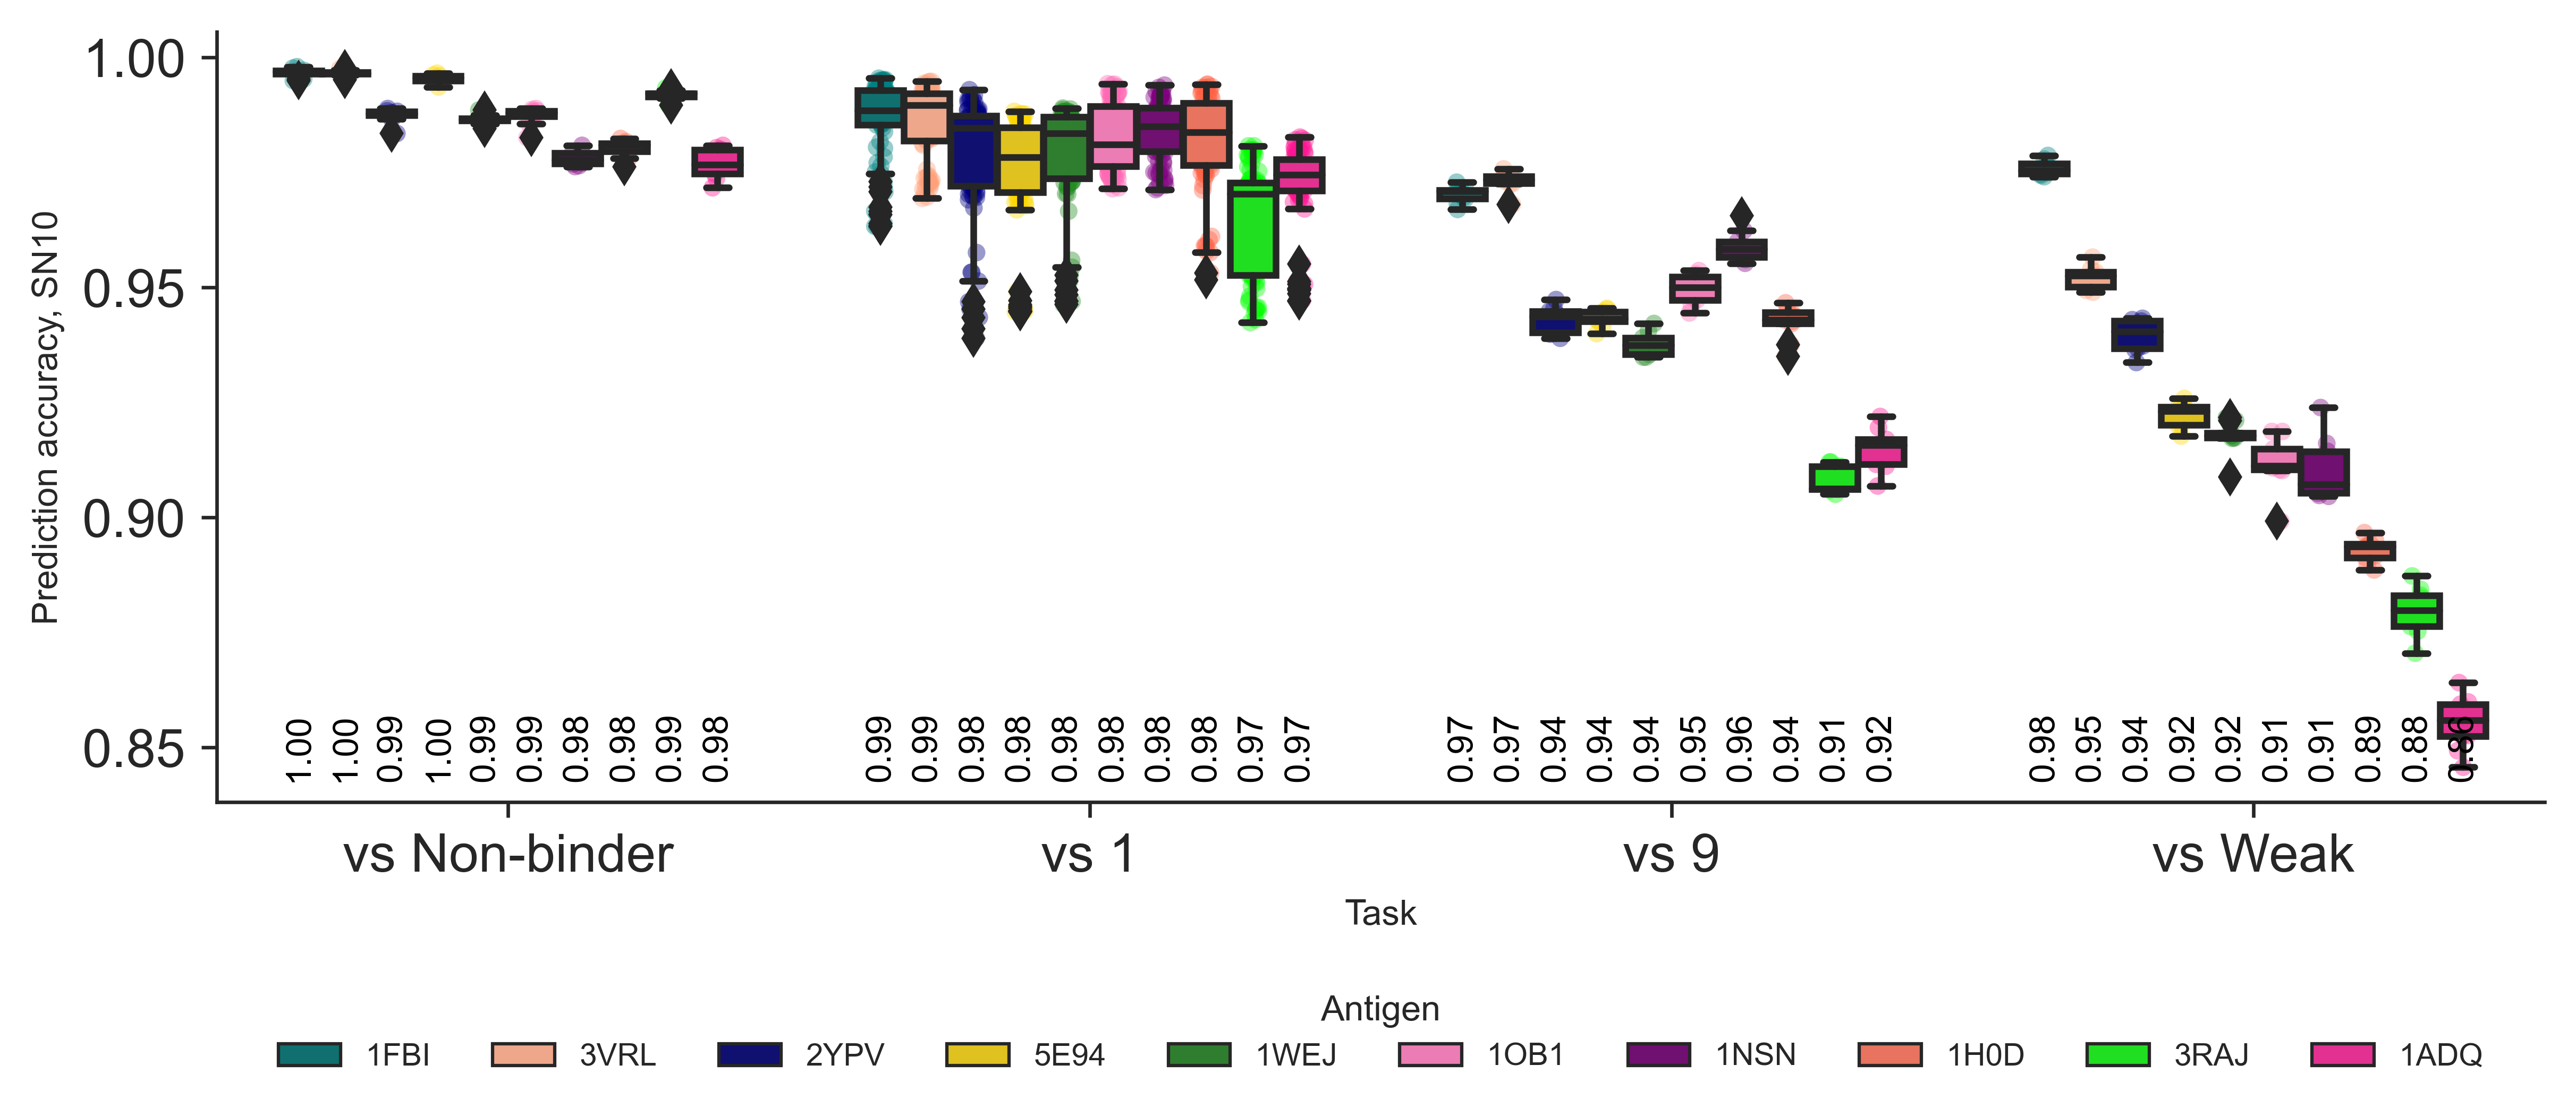

In [11]:
plt.rcParams['svg.fonttype'] = 'none'
#yticks = np.arange(0.85, 1.0, 0.05)
plt.rcParams['svg.fonttype'] = 'none'
yaxis_title = "Prediction accuracy, SN10"
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]
#task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_clean_order = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']#['vs Non-binder','vs 1', 'vs 9', 'vs Loose']

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

stripplot = sns.stripplot(
    x="train_task",
    y="acc",
    hue="train_ag",
    data=df_closed,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=pellets['antigens'],
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
    zorder=1 
)

# Transparent boxplot
boxplot = sns.boxplot(
    x="train_task",
    y="acc",
    hue="train_ag",
    data=df_closed,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=pellets['antigens'],
    boxprops=dict(alpha=1),
    zorder=2
    )

for artist in stripplot.collections:
    artist.set_zorder(1)

# Set the z-order of the boxplot patches to be higher than that of the stripplot
for artist in boxplot.patches:
    artist.set_zorder(2)

add_median_labels(ax, y_level=0.85, fontsize=8)


ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

ax.set_xlabel("Task", fontsize=8)
ax.set_ylabel(yaxis_title, fontsize=8)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig('./figures/by_task_closed.svg')

In [12]:
EXECUTE = False
if EXECUTE:
    jsds = []
    for task in tasks:
        datasets_paths = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_*/split_*/*/*_test_dataset.tsv') #why we did on test? see what happens on train.
        for path in datasets_paths:
            df = pd.read_csv(path, sep='\t')
            slides_pos = df[df['y'] == 1]['Slide'].to_list()
            slides_neg = df[df['y'] == 0]['Slide'].to_list()
            jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
            train_task = task
            seed = path.split('/')[4].split('_')[1]
            split = path.split('/')[5].split('_')[1]
            if task == 'vs 1':
                train_ag = path.split('/')[6].split('__')[0]
                train_neg = path.split('/')[6].split('__')[2]
                seed = int(path.split('/')[4].split('_')[1])
                split = int(path.split('/')[5].split('_')[1])
            else:
                train_ag = path.split('/')[6].split('__')[0].split('_')[0]
                train_neg = 'auto'
            try:
                acc = df_closed[(df_closed['train_task'] == train_task) & (df_closed['train_ag'] == train_ag) &\
                        (df_closed['train_neg'] == train_neg) & (df_closed['seed_id'] == seed) & (df_closed['split_id'] == split)]['acc'].values[0]
                jsds.append([train_task, jsd, acc, train_ag, train_neg, seed, split])
            except:
                print(path)
    df_jsds = pd.DataFrame(jsds, columns=['train_task', 'jsd', 'acc', 'train_ag', 'train_neg', 'seed', 'split'])
    df_jsds.to_csv('./jsd_ection1.csv')

In [13]:
df_jsds = pd.read_csv('./jsd_ection1.csv')
df_jsds.drop('Unnamed: 0', axis=1, inplace=True)

In [28]:
df_jsds_means = df_jsds.groupby(['train_ag','train_neg', 'train_task']).mean().reset_index()


In [29]:
df_jsds_means

,train_ag,train_neg,train_task,jsd,acc,seed,split
0,1ADQ,1FBI,vs 1,3.876352,0.981210,0.6,22.0
1,1ADQ,1H0D,vs 1,3.209635,0.976370,0.6,22.0
2,1ADQ,1NSN,vs 1,3.478722,0.976320,0.6,22.0
3,1ADQ,1OB1,vs 1,3.243824,0.978380,0.6,22.0
4,1ADQ,1WEJ,vs 1,3.581892,0.972260,0.6,22.0
...,...,...,...,...,...,...,...
115,5E94,3RAJ,vs 1,2.916260,0.945860,0.6,22.0
116,5E94,3VRL,vs 1,4.926536,0.982400,0.6,22.0
117,5E94,auto,vs 9,2.872243,0.943452,0.6,22.0
118,5E94,auto,vs Non-binder,3.530181,0.995350,0.6,22.0


In [69]:
df_jsds_means['dupl_filter'] = df_jsds_means.apply(lambda row: str('_'.join(sorted([row['train_ag'],row['train_neg']])) + '_' + row['train_task']), axis=1)

In [70]:
df_jsds_means_wo_dupl = df_jsds_means.drop_duplicates('dupl_filter')

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_17204/1765500532.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


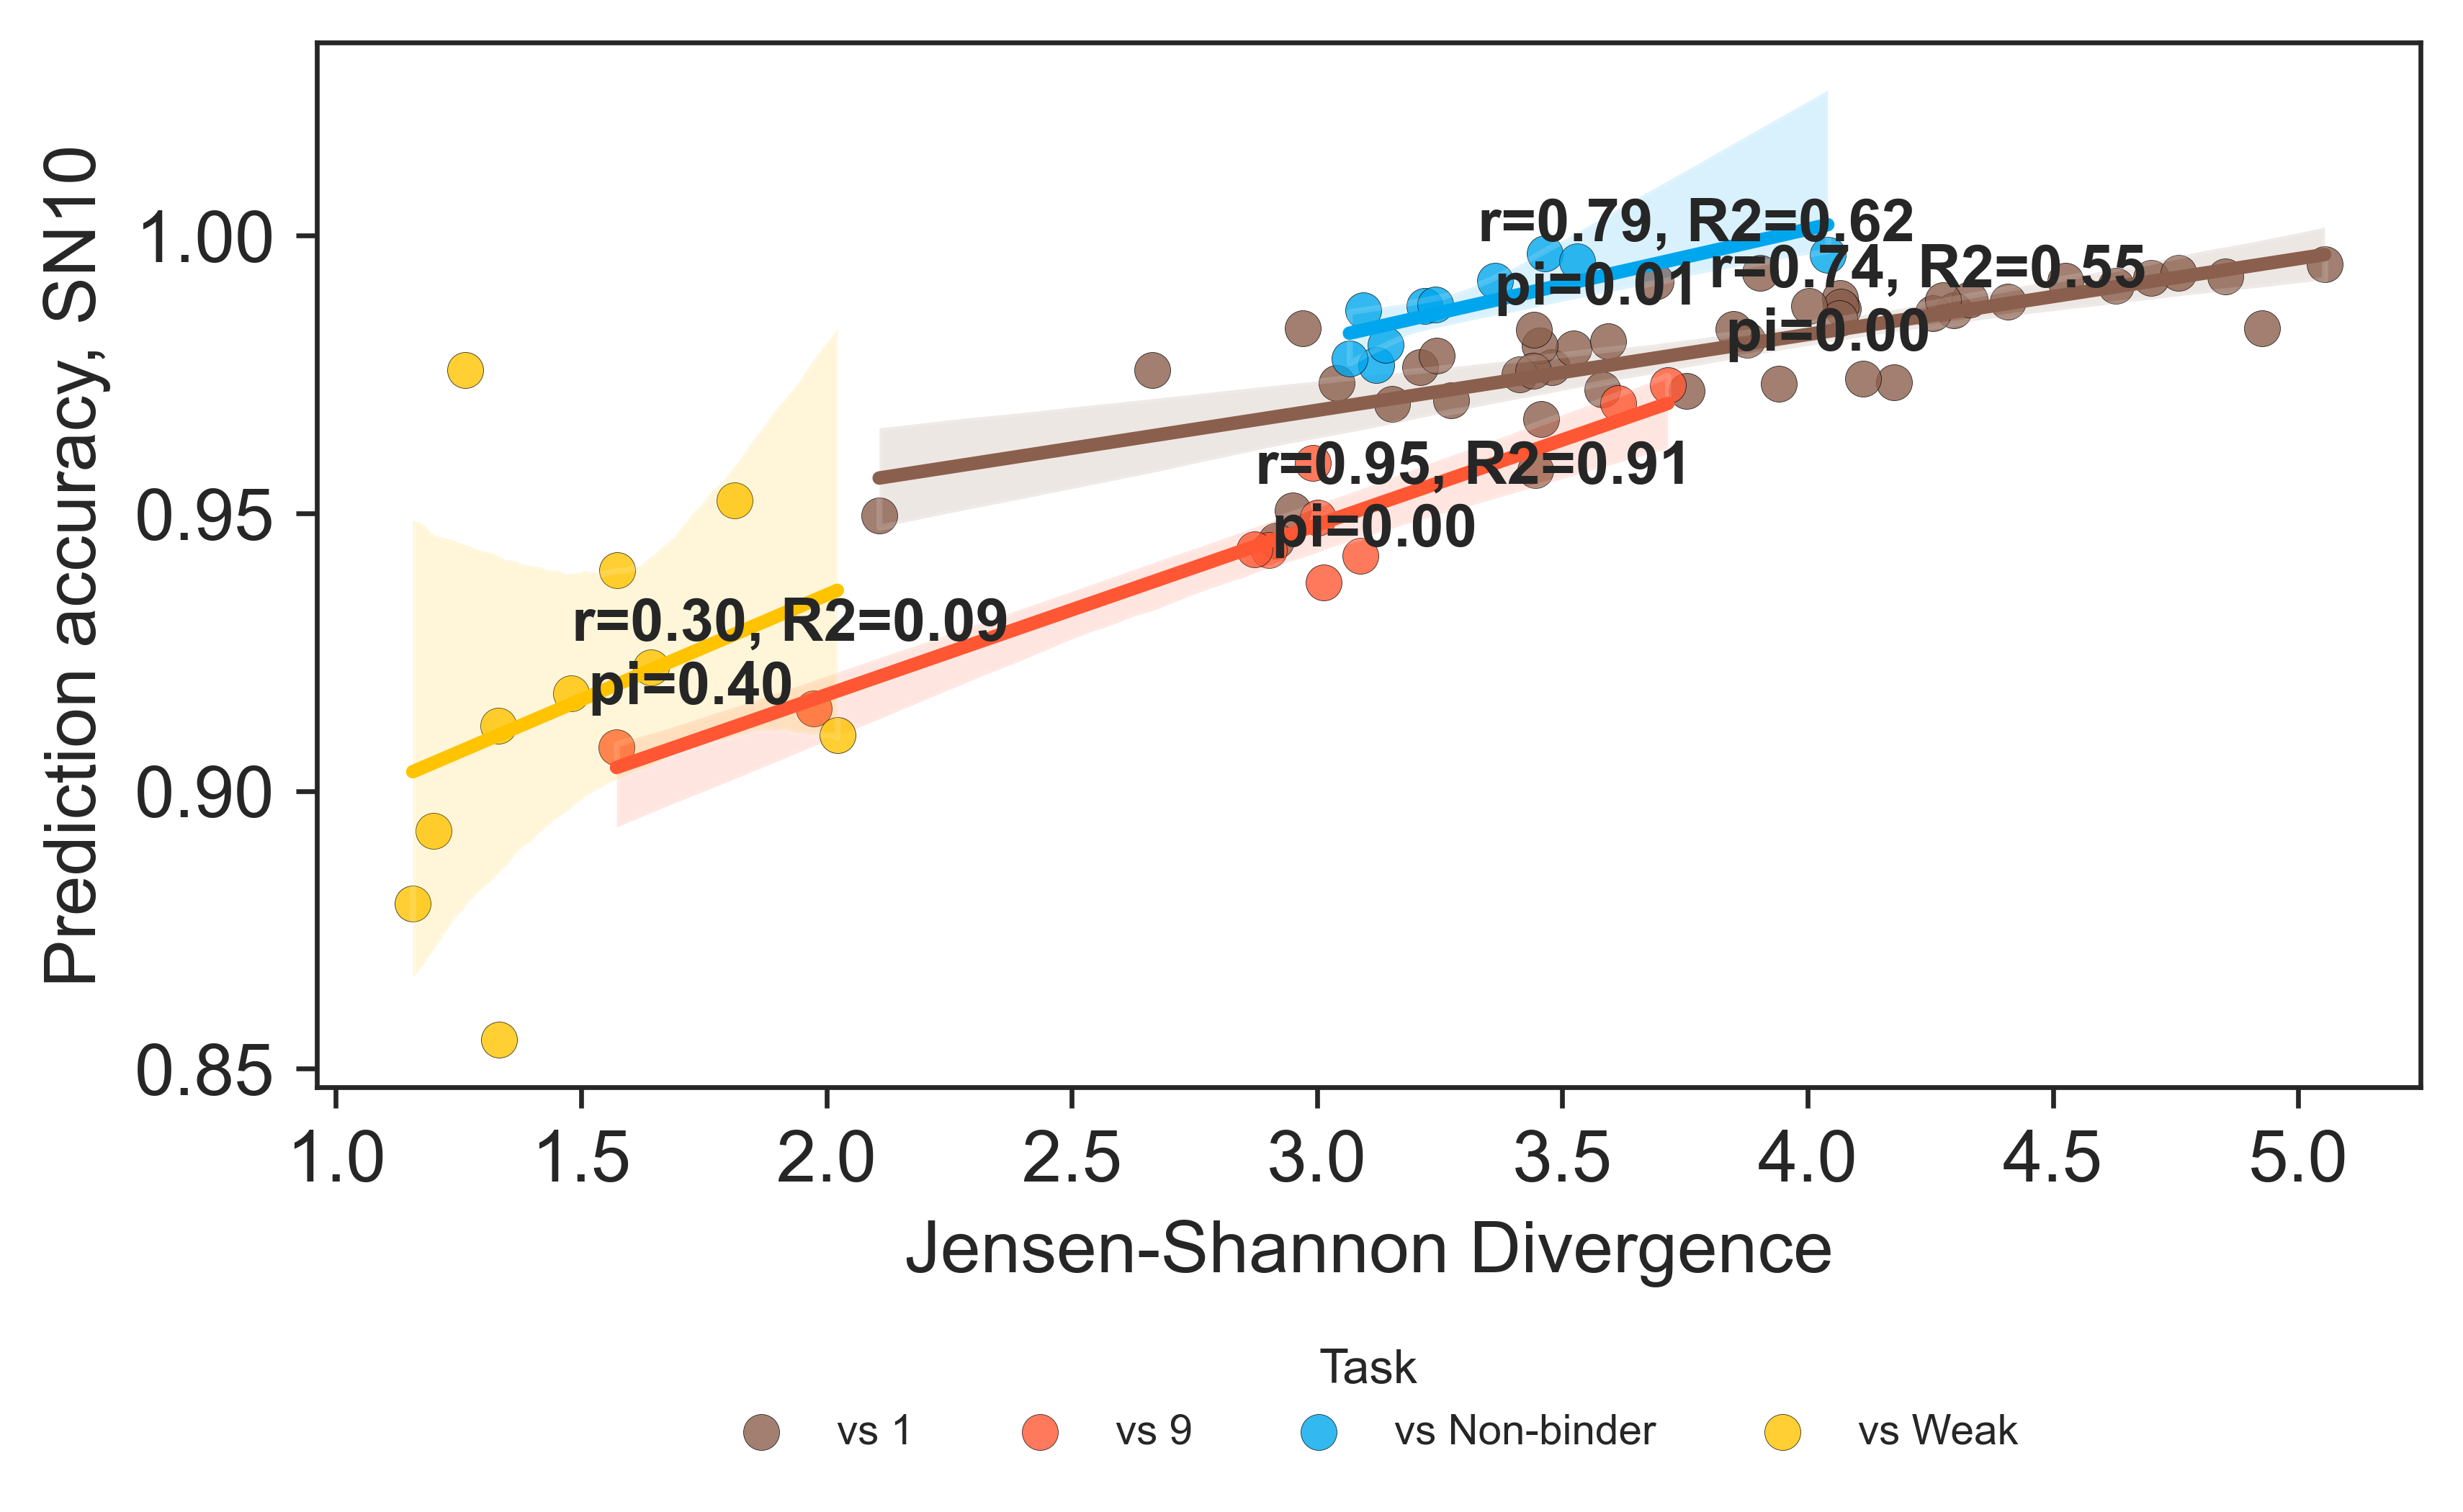

In [73]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in df_jsds_means_wo_dupl.groupby("train_task"):
    sns.regplot(
        x="jsd",
        y="acc",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc"])
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
fig.savefig('./figures/closed_jsd_vs_acc_avg.svg')

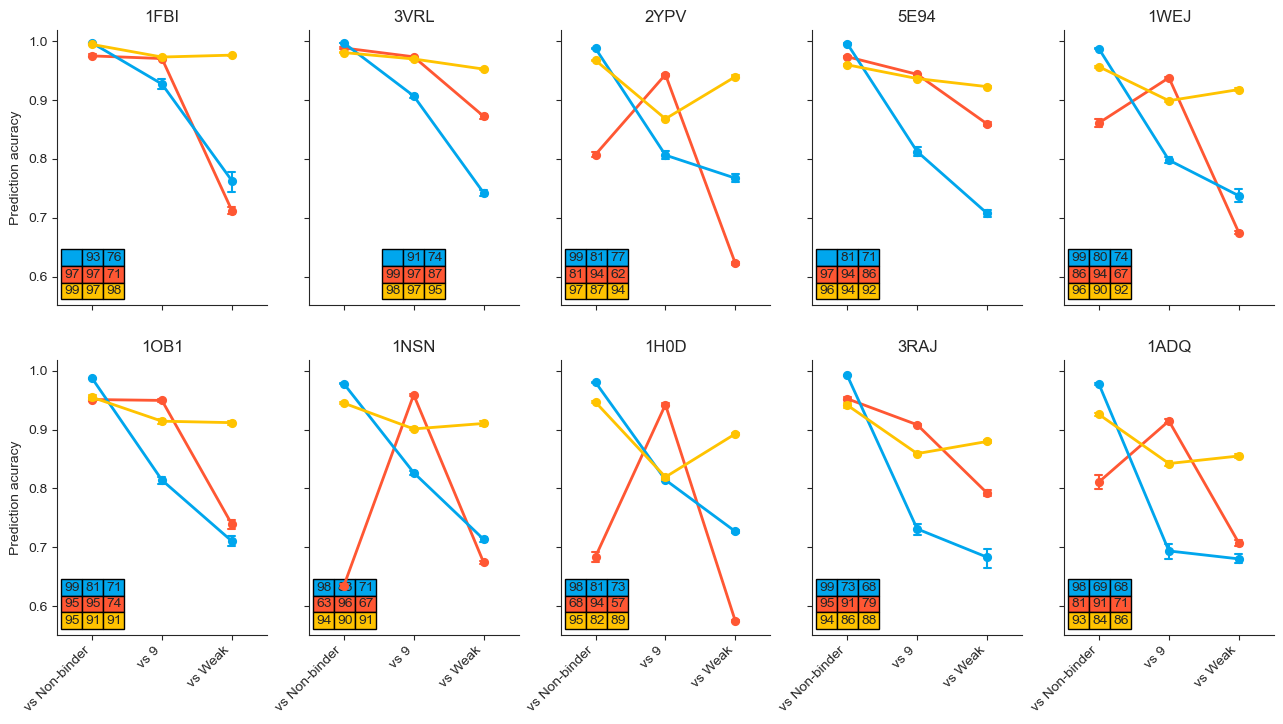

In [74]:
#open performance
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]
fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 2.5* 3.14), sharey=True, sharex=True)
sns.set_style('ticks')
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    sns.pointplot(perf_wo_1[perf_wo_1['train_ag'] == ag], x='test_task', y='acc', order = ['vs Non-binder', 'vs 9', 'vs Weak'],  \
        hue='train_task',  errorbar= ('ci', 95),  palette = cmap, ax=ax[r,c], scale=0.75, capsize=.1, errwidth=1.5)
    ax[r,c].legend().set_visible(False)
    ax[r,c].set_title(ag, fontsize=12)
    # set_horizontalalignment 

    if c!=0:
       ax[r,c].set_ylabel('')
    else:
        ax[r,c].set_ylabel('Prediction acuracy')
    #remove xlabel
    ax[r,c].set_xlabel('')

    #rotate xticks
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(), rotation=45) 
    for tick in ax[r,c].get_xticklabels():
        tick.set_horizontalalignment("right")

    #set font size
    #ax[r,c].tick_params(axis='both', which='major', labelsize=8)
    #REMOVE upper and right spines
    ax[r,c].spines['right'].set_visible(False)
    ax[r,c].spines['top'].set_visible(False)

     # Tables inside the plot
    if r == 0 and c == 1:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (perf_wo_1[perf_wo_1['train_ag'] == ag].groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")\
    .reindex(['vs Non-binder', 'vs 9', 'vs Weak'], axis=1).reindex(['vs Non-binder', 'vs 9', 'vs Weak'], axis=0)\
    .values * 100).round().astype('int')
    table_values = np.where(table_values == 100, "", table_values)
    ax[r,c].table(
        cellText=table_values,
        loc=loc,
        colWidths=[0.1, 0.1, 0.1],
        cellColours=np.array([['#00A6ED', '#FF5733', '#FFC300'] for _ in range(3)]).transpose(),
    )
    #line width 
    



# set common x axis label
#fig.text(0.5, 0, 'Test task', ha='center', va='center')

#one legend for all subplots
handles, labels = ax[0,0].get_legend_handles_labels()
"""fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)"""
fig.savefig('./figures/openset_performance.svg')

#TODO: change x-labels, y-label, make y-tick labels bigger, add lehend with handles 


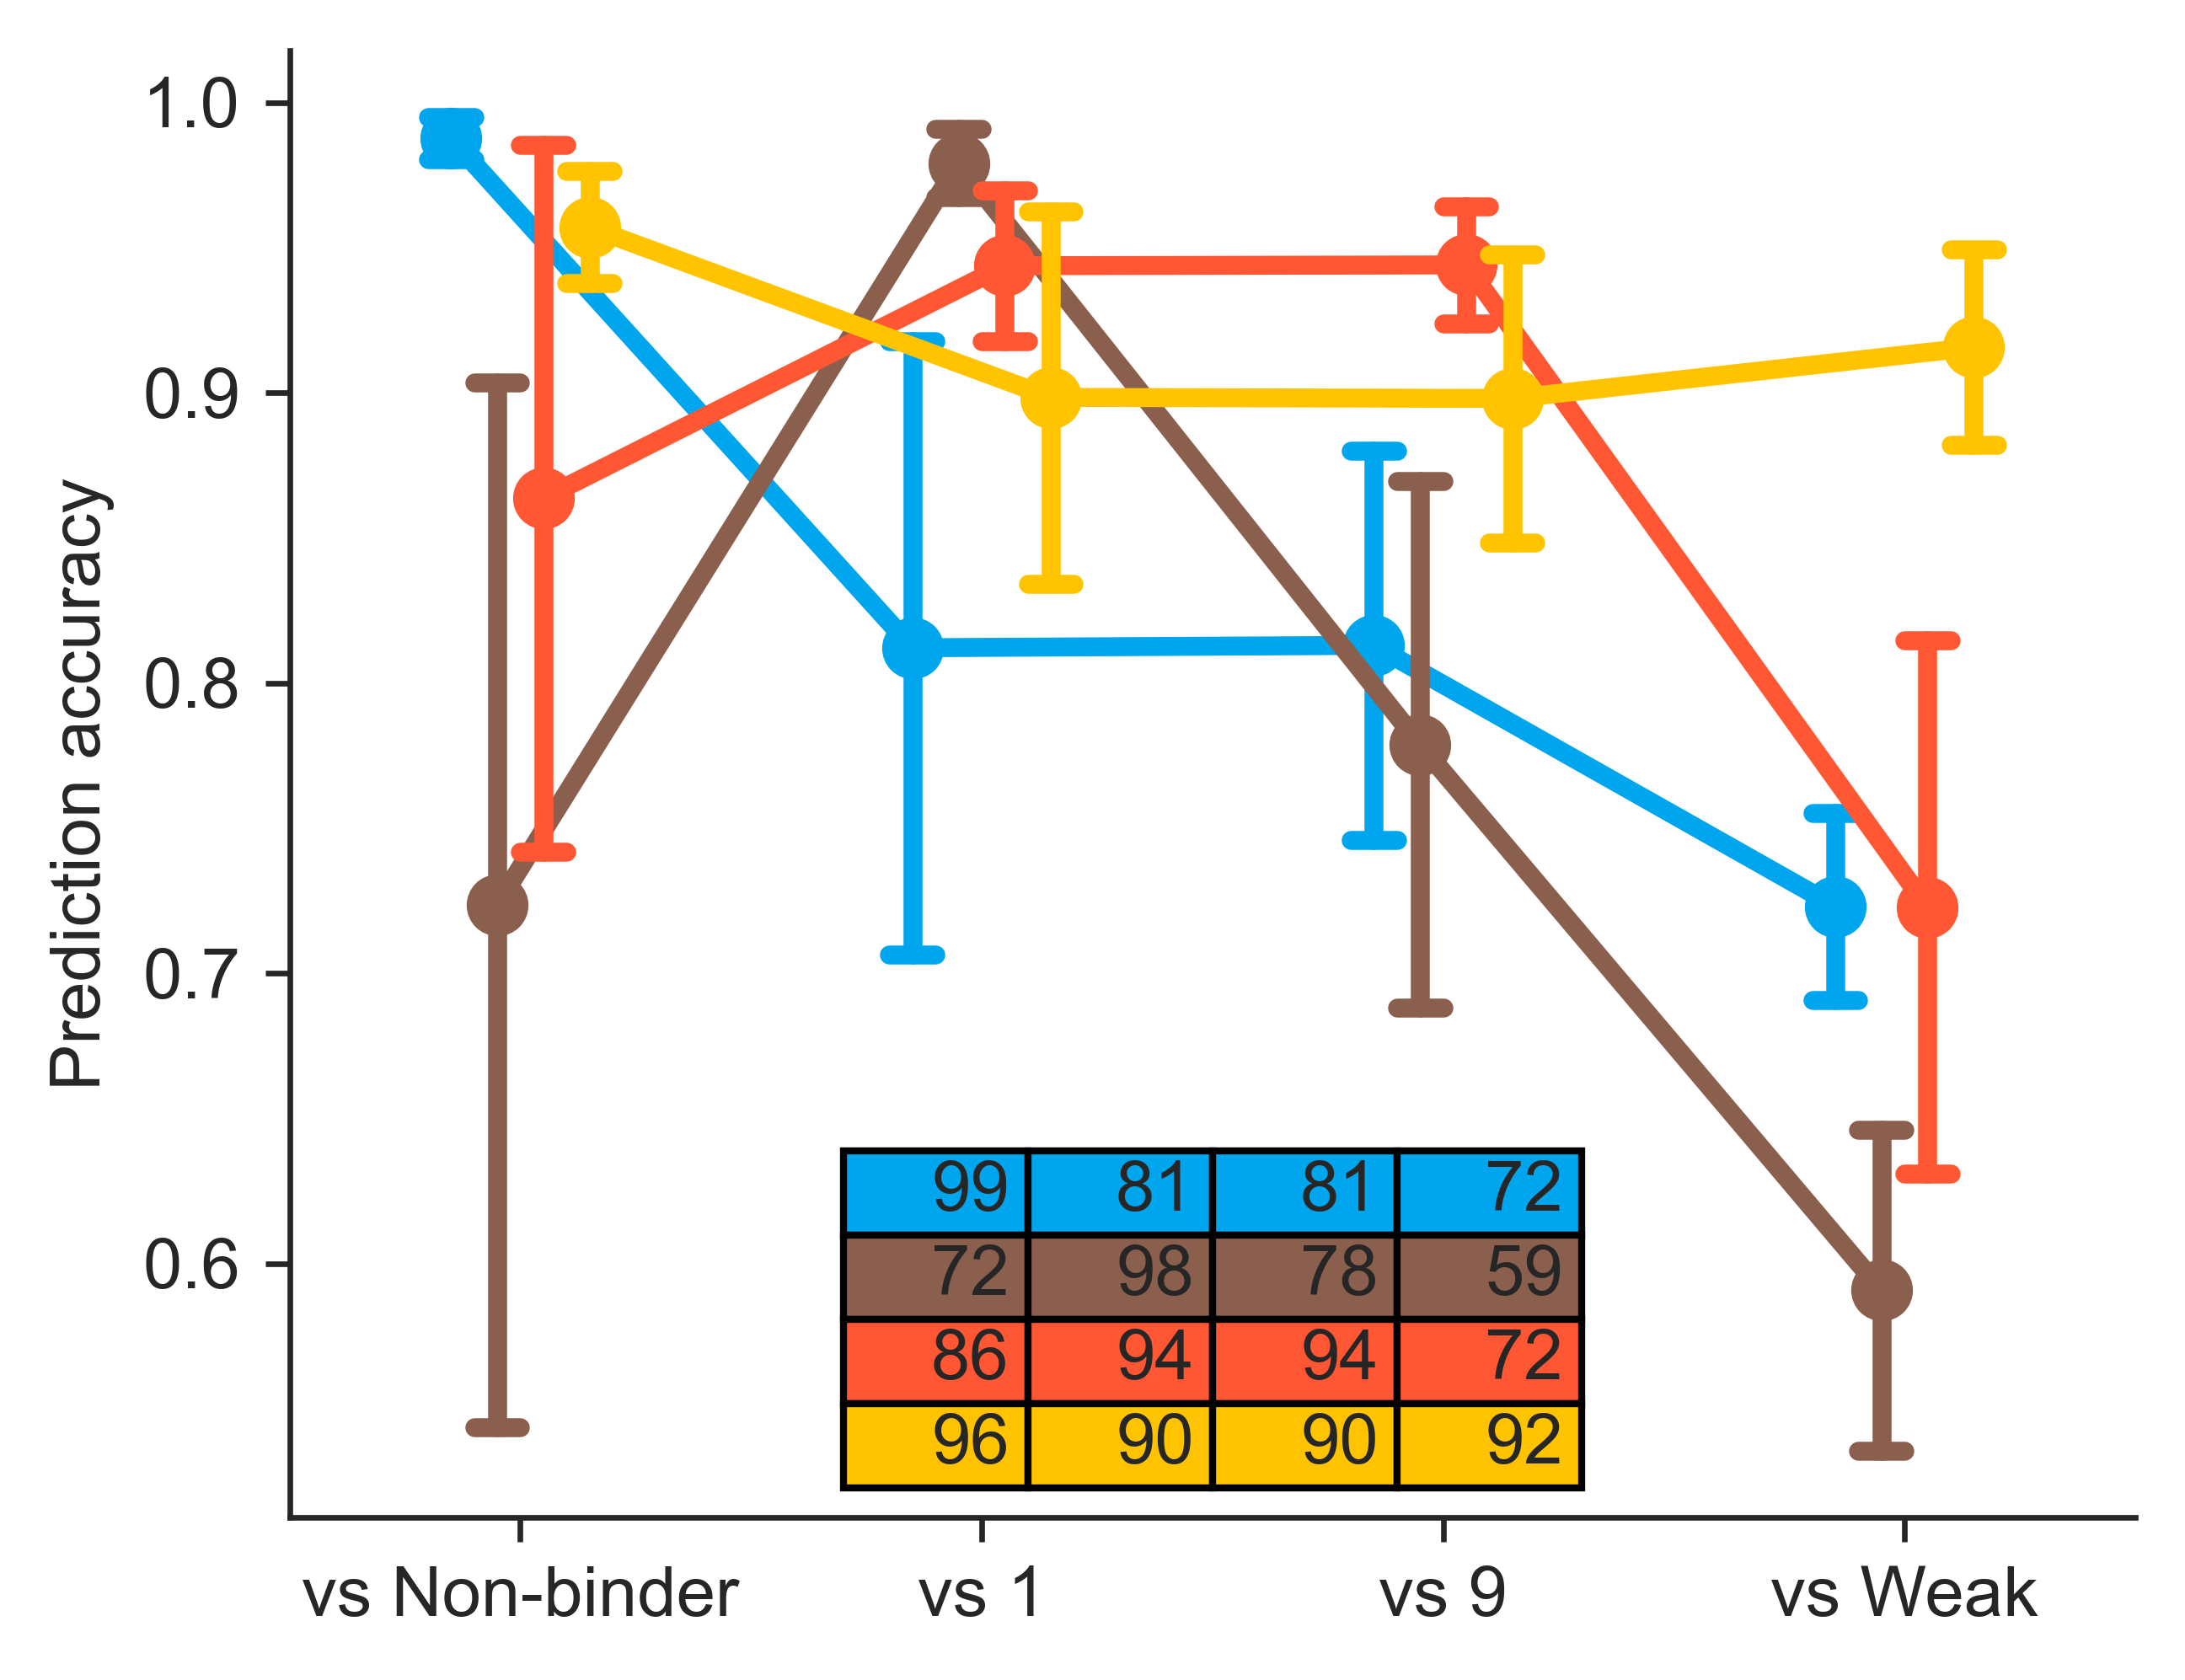

In [75]:
fig, ax = plt.subplots(figsize=(1.5* 3.14, 1.2 * 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')
task_order_3 = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']
sns.pointplot(
    perf_df,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order_3,
    hue="train_task",
    hue_order = task_order_3,
    palette= [cmap[task] for task in task_order_3],
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
    capsize=0.1,
    estimator='mean'
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().set_visible(False)

#table
table_values = (perf_df.groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")
    .loc[['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']]\
    .values * 100).round().astype('int')
    #table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc='lower center',
    colWidths=[0.1]*4,
    cellColours=np.array([['#00A6ED', '#8B5F4D', '#FF5733', '#FFC300'] for _ in range(4)]).transpose(),
    )

fig.savefig('./figures/joined_perf_by_task.svg')

In [76]:
df_open_full = pd.concat([pd.read_csv('../data/1vs1_open.csv'), perf_open_df[['acc', 'recall', 'precision', 'f1', 'train_task', 'train_ag',\
       'train_neg', 'seed_id', 'split_id', 'test_task', 'test_ag', 'test_neg','test_seed_id', 'test_split_id']]],axis = 0)

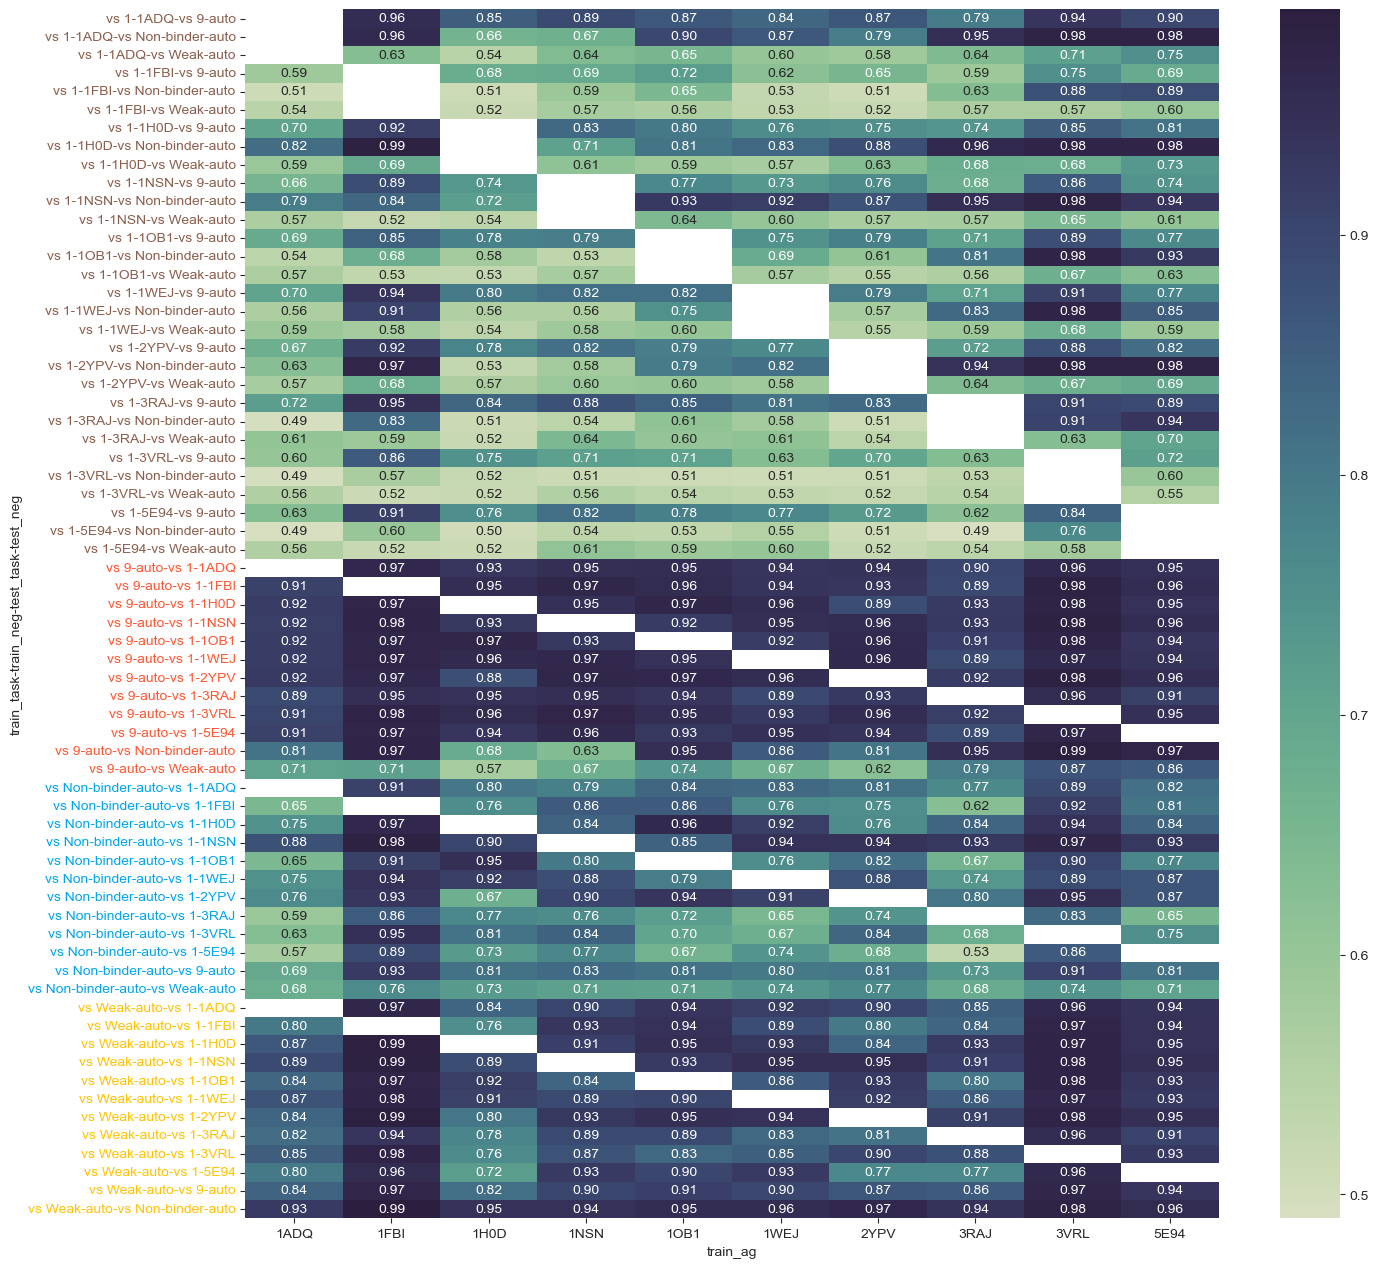

In [78]:
#remove  where train and test task "vs 1"
custom_pel = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
df_open_wo1vs1 = df_open_full[df_open_full['train_task'] != df_open_full['test_task']]
fig, ax = plt.subplots(1,1,figsize= (5 * 3.14, 5* 3.14), sharey=True, sharex=True)
sns.heatmap(df_open_wo1vs1.pivot_table(index=['train_task','train_neg','test_task','test_neg'], columns=['train_ag'], values='acc'), cmap=custom_pel, ax=ax, annot=True, fmt=".2f")
#color rowlabels by 'train_task'
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
for tick in ax.get_yticklabels():
    #get label name
    label = tick.get_text()
    label = label.split('-')[0]
    #set color
    if label == 'vs Non':
        label = 'vs Non-binder'
    tick.set_color(cmap[label])

fig.savefig('./figures/openset_performance_wo1vs1.svg')


### JSD open performace

In [89]:
jsd_dict  = dict()
for i in range(df_jsds.shape[0]):
    row = df_jsds.iloc[i]
    jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed']), int(row['split'])] = row['jsd']

closed_acc_dict = dict()
for i in range(df_closed.shape[0]):
    row = df_closed.iloc[i]
    closed_acc_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])] = row['acc']

perf_open_df['train_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
perf_open_df['test_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['test_task'], row['test_ag'],row['test_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
perf_open_df['closed_acc'] = perf_open_df.apply(lambda row: closed_acc_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)

perf_open_df['delta_jsd'] =  perf_open_df['train_jsd'] - perf_open_df['test_jsd']
perf_open_df['delta_acc'] =  perf_open_df['closed_acc'] - perf_open_df['acc']
perf_open_df.reset_index(inplace=True, drop=True)
perf_open_df['delta_jsd_norm'] = perf_open_df['delta_jsd']/perf_open_df['train_jsd']
perf_open_df['delta_acc_norm'] = perf_open_df['delta_acc']/perf_open_df['closed_acc']

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_17204/806737188.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['train_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_17204/806737188.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['test_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['test_task'],

In [91]:
perf_open_df

,acc,recall,precision,f1,train_task,train_ag,train_neg,seed_id,split_id,test_task,...,test_neg,test_seed_id,test_split_id,train_jsd,test_jsd,closed_acc,delta_jsd,delta_acc,delta_jsd_norm,delta_acc_norm
0,0.987000,0.9750,0.998975,0.986842,vs 9,3VRL,auto,0,42,vs Non-binder,...,auto,0,42,3.701268,4.024551,0.972986,-0.323283,-0.014014,-0.087344,-0.014403
1,0.882900,0.9750,0.823341,0.892775,vs 9,3VRL,auto,0,42,vs Weak,...,auto,0,42,3.701268,1.781520,0.972986,1.919747,0.090086,0.518673,0.092588
2,0.912356,0.9980,0.852117,0.919307,vs Non-binder,3VRL,auto,0,42,vs 9,...,auto,0,42,4.024551,3.701268,0.996600,0.323283,0.084244,0.080328,0.084531
3,0.758500,0.9980,0.674780,0.805163,vs Non-binder,3VRL,auto,0,42,vs Weak,...,auto,0,42,4.024551,1.781520,0.996600,2.243030,0.238100,0.557337,0.238912
4,0.968284,0.9604,0.975818,0.968048,vs Weak,3VRL,auto,0,42,vs 9,...,auto,0,42,1.781520,3.701268,0.953400,-1.919747,-0.014884,-1.077589,-0.015612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0.940700,0.9946,0.897815,0.943733,vs Non-binder,1OB1,auto,2,42,vs 1,...,2YPV,NaN,NaN,3.227477,4.322922,0.988700,-1.095445,0.048000,-0.339412,0.048549
5396,0.953800,0.9228,0.983795,0.952322,vs Weak,1OB1,auto,2,42,vs 1,...,2YPV,NaN,NaN,1.314818,4.322922,0.910800,-3.008105,-0.043000,-2.287850,-0.047211
5397,0.974300,0.9636,0.984672,0.974022,vs 9,1OB1,auto,3,42,vs 1,...,2YPV,NaN,NaN,2.997984,4.322922,0.953677,-1.324938,-0.020623,-0.441943,-0.021625
5398,0.922000,0.9958,0.867724,0.927361,vs Non-binder,1OB1,auto,3,42,vs 1,...,2YPV,NaN,NaN,3.227477,4.322922,0.985600,-1.095445,0.063600,-0.339412,0.064529


In [ ]:
# I need to write down how I filter sequences
perf_open_df['dupl_filter'] = perf_open_df.apply(lambda row: '_'.join(row[['train_ag','train_neg']]) + '_' + '_'.join(row[['train_task','test_task']].values) + '_' + '_'.join(sorted(row[['test_ag', 'test_neg']])), axis=1)

In [85]:
perf_open_df_means = perf_open_df.groupby(['train_ag','train_neg','train_task','test_task','test_ag', 'test_neg']).mean().reset_index()

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_17204/2184547724.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


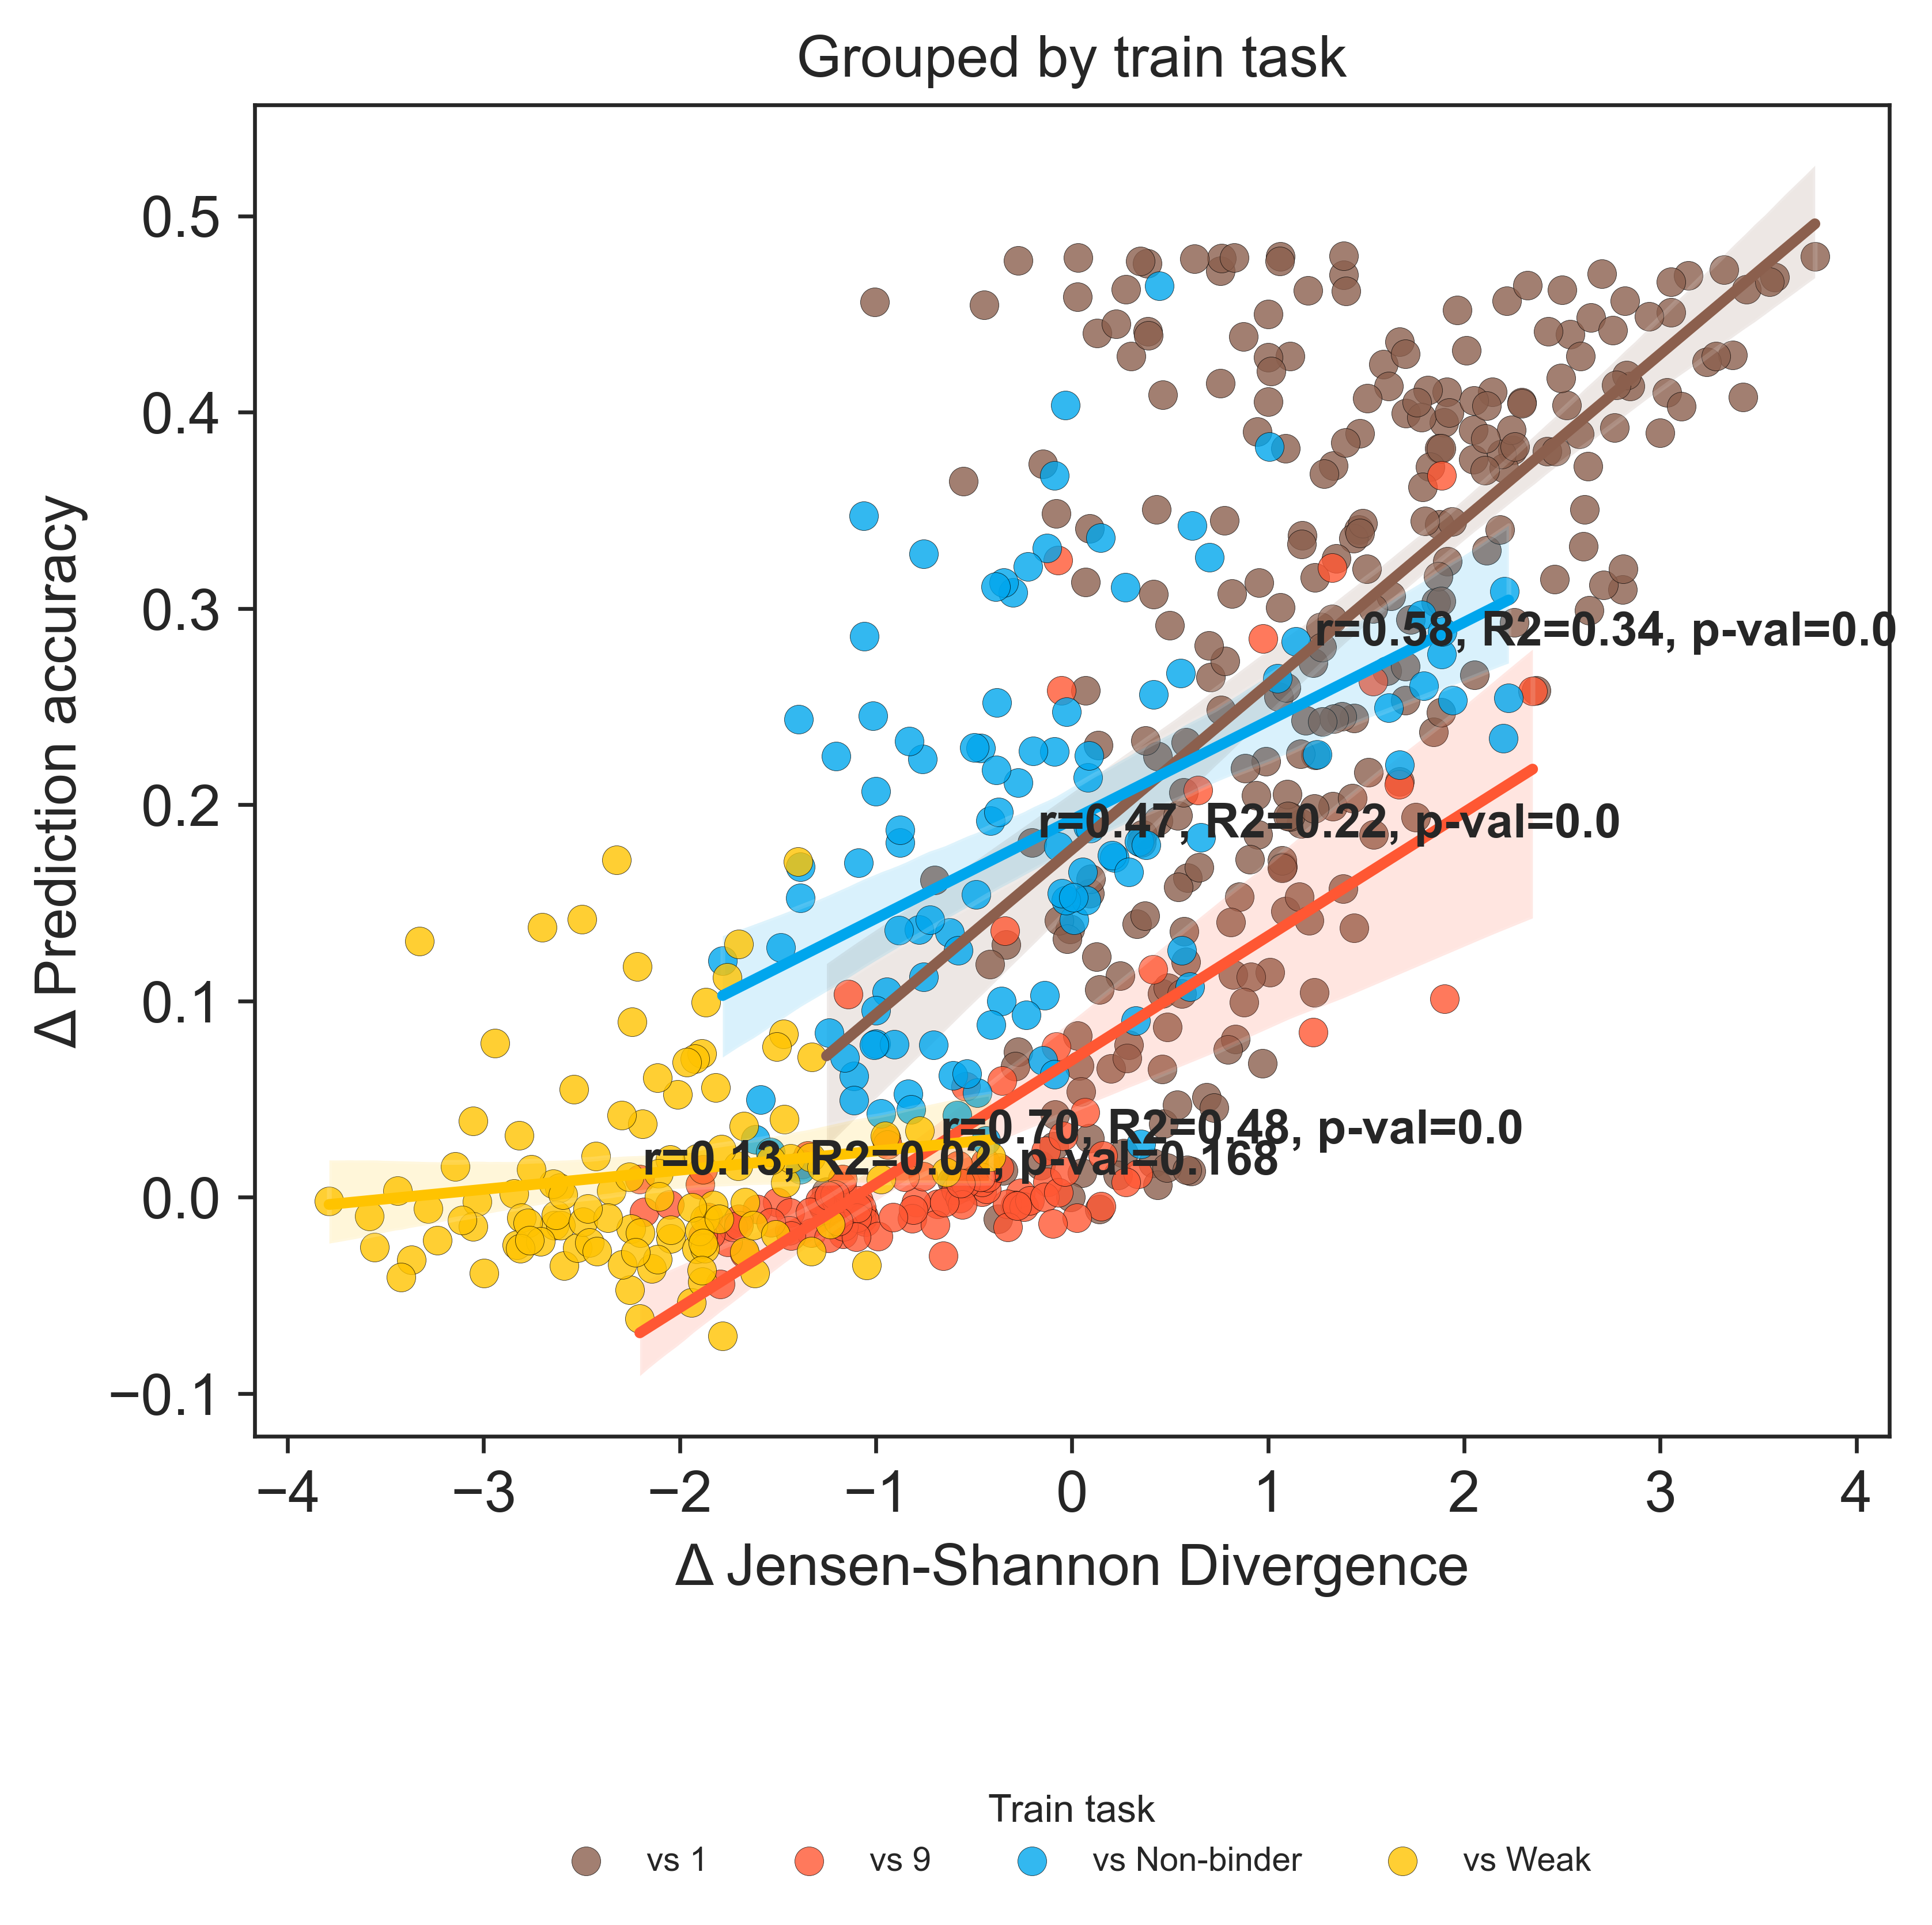

In [92]:
#matters how I calculate delta

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
marker_styles = { 'vs 9' : 'o',
         'vs Non-binder':'^',
         'vs Weak':'X',
         'vs 1': '8'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5*1.22, 5), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in perf_open_df_means.groupby("train_task"):
    sns.regplot(
        y="delta_acc",
        x="delta_jsd",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
    # Add text with r and R2 at centroid
    x = df_g["delta_jsd"].mean()
    y = df_g["delta_acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}, p-val={pval.round(3)}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Δ Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel("Δ Prediction accuracy", fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)


# put legend to the bottom
ax.legend(bbox_to_anchor=(0.5, -0.3), loc="center", borderaxespad=0.0, fontsize=7, title="Train task", title_fontsize=8, ncol=10, frameon=False)
#remove legend
#ax.get_legend().remove()
ax.set_title('Grouped by train task')

fig.show()
#fig.savefig('./figures/delta_jsd_vs_delta_acc_sq.svg')

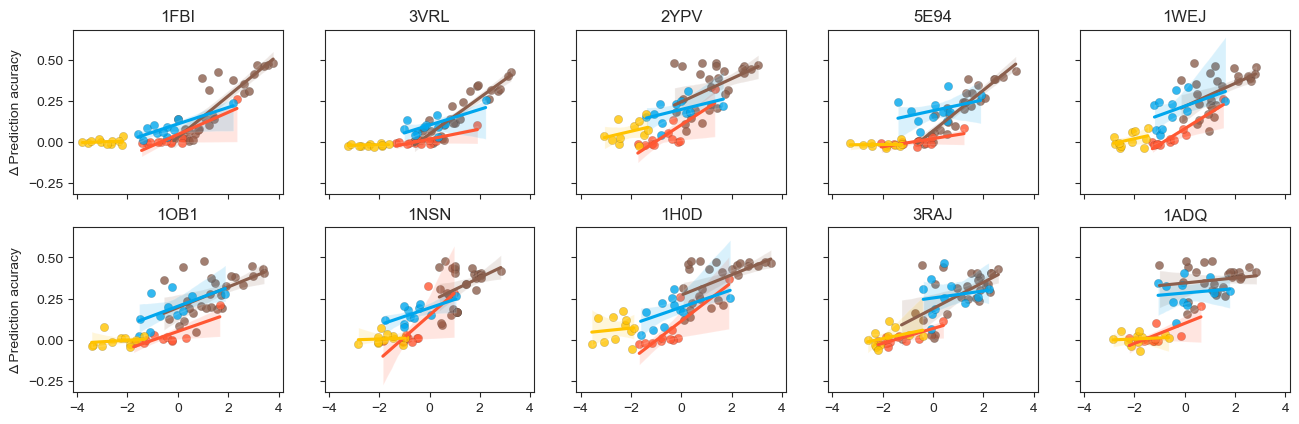

In [107]:
#open performance
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 1.5 * 3.14), sharey=True, sharex=True)
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    df = perf_open_df_means[perf_open_df_means['train_ag'] == ag]
    ax_=ax[r,c]

# Line plot in seaborn with R2 regression
    for task, df_g in df.groupby("train_task"):
        sns.regplot(
            x="delta_jsd",
            y="delta_acc",
            data=df_g,
            scatter=True,
            ax=ax_,
            color=cmap[task],
            scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}
        )

        # Compute Pearson correlation
        r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
        # Add text with r and R2 at centroid
        x = df_g["delta_jsd"].mean()
        y = df_g["delta_acc"].mean()
        r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
        #ax_.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=8, fontweight="bold")

        ax_.set_title(ag, fontsize=12)
        if c!=0:
            ax_.set_ylabel('')
        else:
            ax_.set_ylabel('Δ Prediction acuracy')
        #remove xlabel
        ax_.set_xlabel('')

#save
fig.savefig('./figures/delta_jsd_vs_delta_acc_by_ag.svg')


